In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

In [2]:
import sys
sys.path.append('../')
sys.path.append('/home/artem/git/sdafe')

In [3]:
from sdafe.plot import plot_qq_norm
from sdafe.ch05.univariate import silverman_bw
from sdafe.ch05.mle import mle_se

### 5.19.1 Earnings Data

In [4]:
earnings = pd.read_csv('../data/CPSch3.csv', index_col=0)
earnings.head()

,year,ahe,sex
1,1992,12.999118,male
2,1992,11.617962,male
3,1992,17.377293,male
4,1992,10.061266,female
5,1992,16.756676,male


In [5]:
male_earnings = earnings[earnings.sex == 'male']['ahe']

In [6]:
sqrt_male_earnings = np.sqrt(male_earnings)
log_male_earnings = np.log(male_earnings)

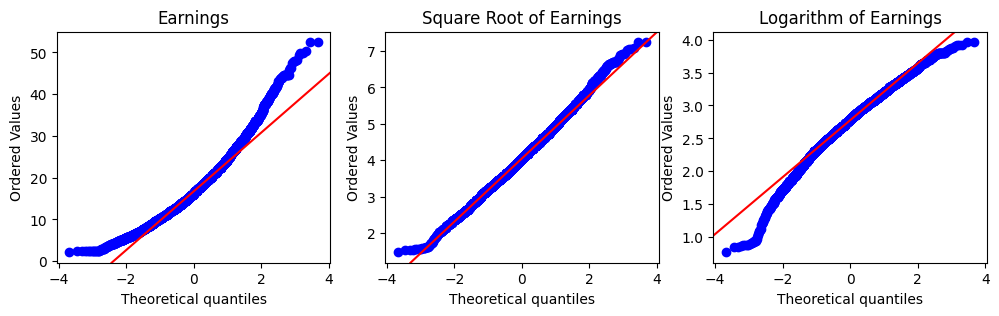

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plot_qq_norm(axs[0], male_earnings)
axs[0].set_title('Earnings')

plot_qq_norm(axs[1], sqrt_male_earnings)
axs[1].set_title('Square Root of Earnings')

plot_qq_norm(axs[2], log_male_earnings)
axs[2].set_title('Logarithm of Earnings');

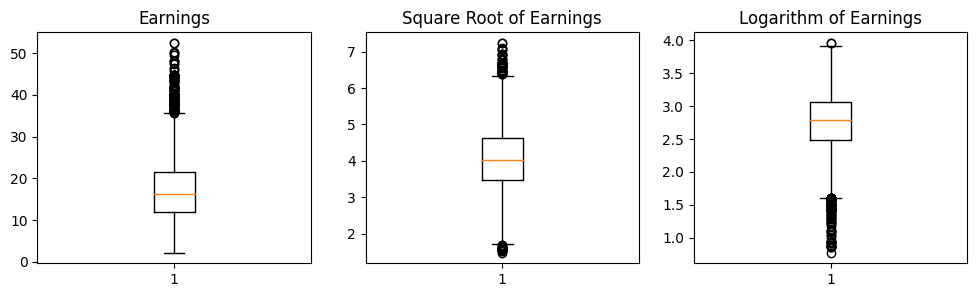

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].boxplot(male_earnings)
axs[0].set_title('Earnings')

axs[1].boxplot(sqrt_male_earnings)
axs[1].set_title('Square Root of Earnings')

axs[2].boxplot(log_male_earnings)
axs[2].set_title('Logarithm of Earnings');

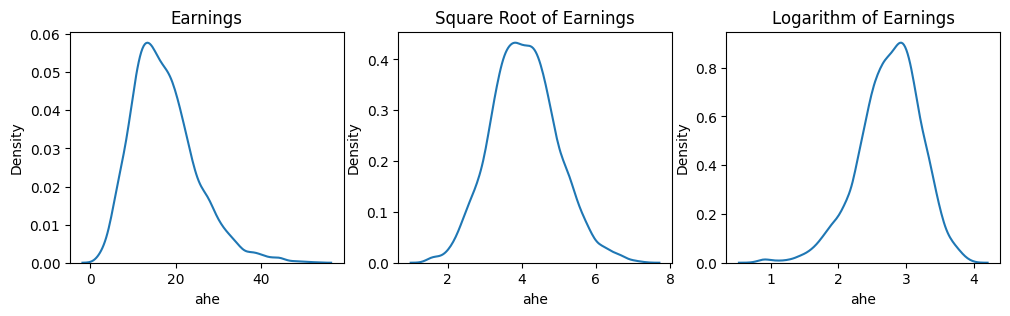

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

sns.kdeplot(male_earnings, ax=axs[0])
axs[0].set_title('Earnings')

sns.kdeplot(sqrt_male_earnings, ax=axs[1])
axs[1].set_title('Square Root of Earnings')

sns.kdeplot(log_male_earnings, ax=axs[2])
axs[2].set_title('Logarithm of Earnings');

The square-root tranformation produces the most symmetric distribution.

In [10]:
powers = np.linspace(0.1, 1.0, 10)

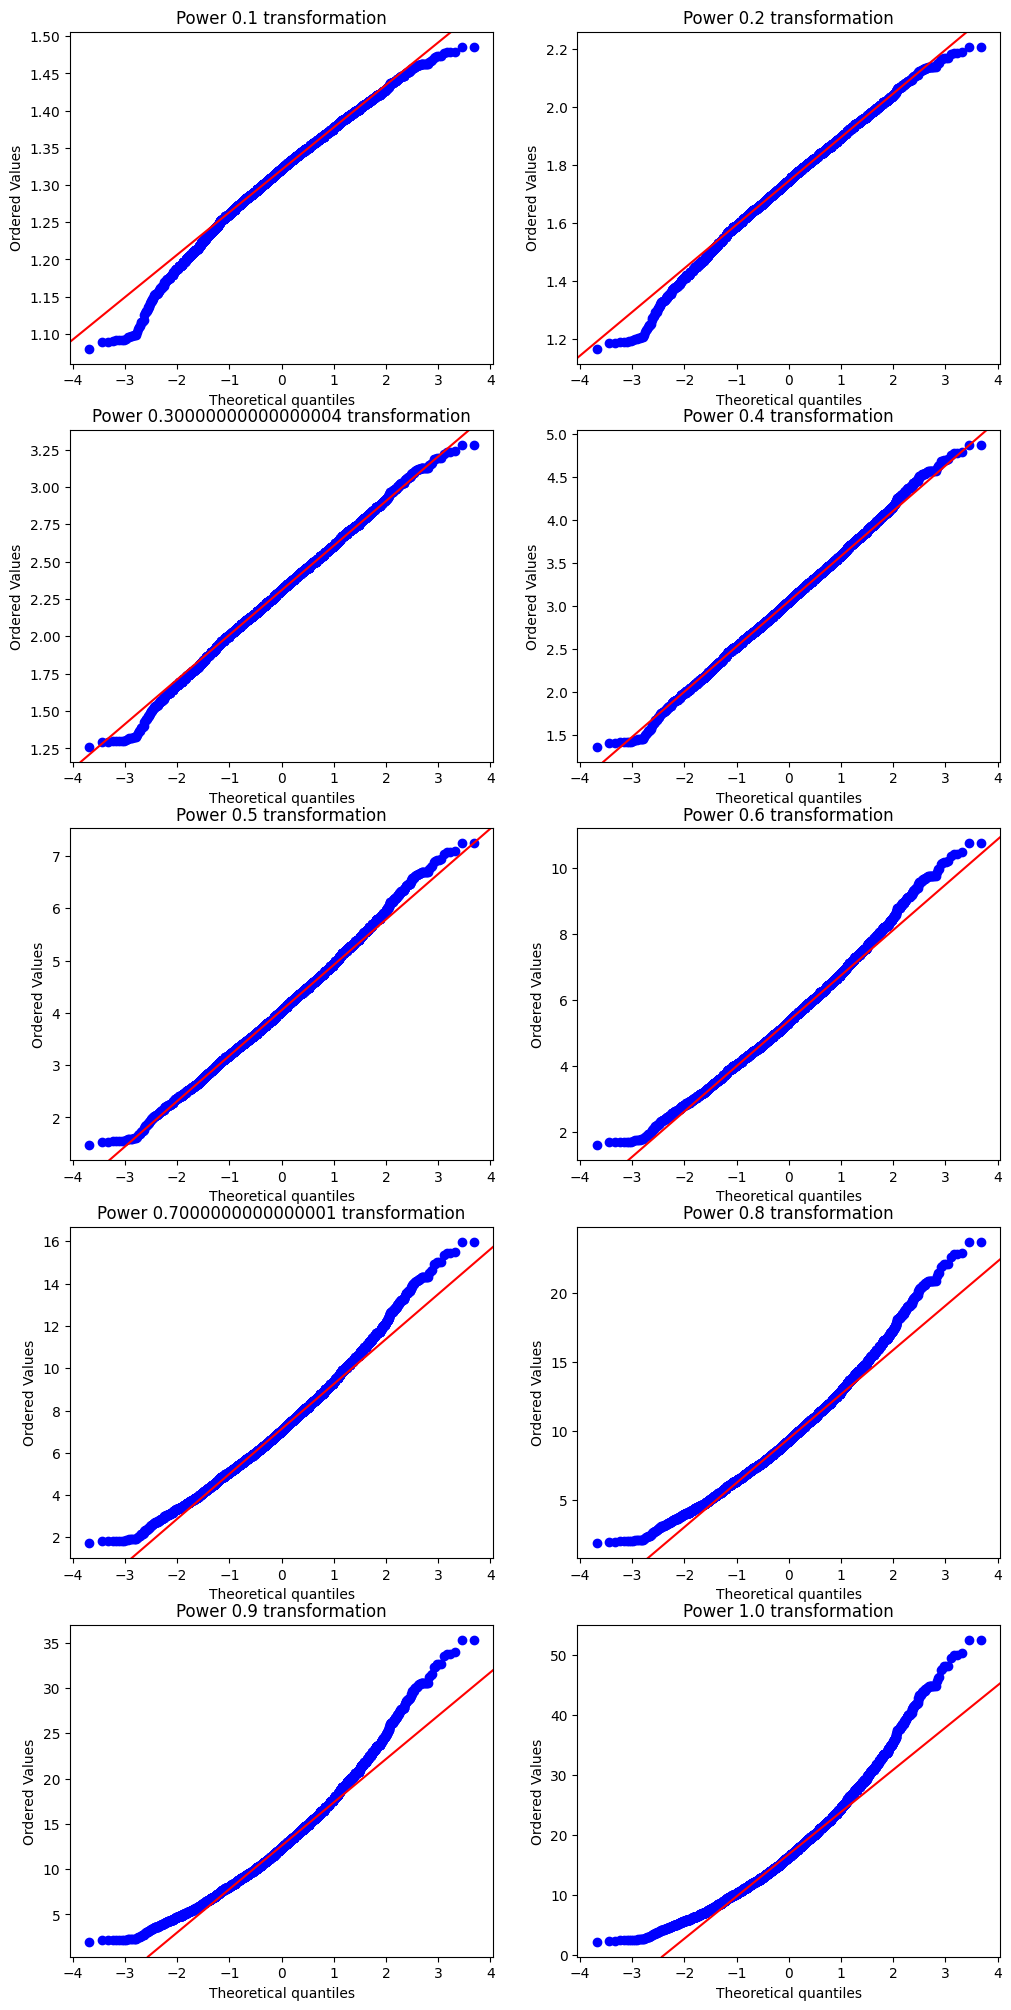

In [11]:
rows = len(powers) // 2
fig, axs = plt.subplots(rows, 2, figsize=(12, 5 * rows))

for i, power in enumerate(powers):
    ax = axs[i // 2][i % 2]
    plot_qq_norm(ax, male_earnings ** power)
    ax.set_title(f'Power {power} transformation')

Power 0.4 tranformation seems to provide the best overall fit.

In [12]:
(bc_male_earnings, maxlog, conf_int) = stats.boxcox(male_earnings, alpha=0.05)

In [13]:
maxlog

0.36109587478535093

In [14]:
conf_int

(0.31674754105703745, 0.405693830714108)

#### Problem 2

(a) ``ind`` selects those values of $\lambda$ for which the likelihood reaches its maximum value, and ``ind2`` selects the values that are within the confidence interval of the maximum.

(b) The effect is to use spline interpolation which gives additional precision in the resulting parameters.

(c) The MLE at $\lambda$:

In [15]:
def r_loglik(xs, lmd, eps=0.02):
    """Reproduces the likelihood returned by the boxcox function in the MASS package in R"""
    n = len(xs)
    x_norm = xs / np.exp(np.mean(np.log(xs)))
    if lmd > eps:
        yt = (x_norm ** lmd - 1) / lmd
    else:
        logx = np.log(x_norm)
        yt = logx * (1 + (lmd * logx) / 2 * (1 + (lmd * logx) / 3 * (1 + (lmd * logx) / 4)))
    return - n / 2 * np.log(np.sum((yt - np.mean(yt)) ** 2))

In [16]:
r_loglik(male_earnings, maxlog)

-21131.776077021364

(d) The 95% confidence interval is (0.317, 0.406).

(e) The 99% confidence interval is:

In [17]:
(_, _, conf_int) = stats.boxcox(male_earnings, alpha=0.01)
conf_int

(0.30286395208197975, 0.41975891060349885)

In [18]:
from common.distr import dsstd

In [19]:
x = male_earnings

In [20]:
loglik_f = lambda beta: np.sum(-np.log(dsstd(x, mean=beta[0], sd=beta[1], nu=beta[2], xi=beta[3])))

In [21]:
start = np.array([np.mean(x), np.std(x, ddof=1), 5, 1])

In [22]:
fit_t = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None), (0, None)])
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20121.410107113843
        x: [ 1.732e+01  7.492e+00  2.160e+01  1.652e+00]
      nit: 20
      jac: [-4.729e-03 -1.091e-03 -7.276e-04  3.092e-02]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

The estimate of the degrees of freedom:

In [23]:
fit_t.x[2]

21.598159231227715

The estimate of $\xi$:

In [24]:
fit_t.x[3]

1.6516898030791656

#### Problem 4

The skewed t-distribution produces a very good approximation of the empirical density.

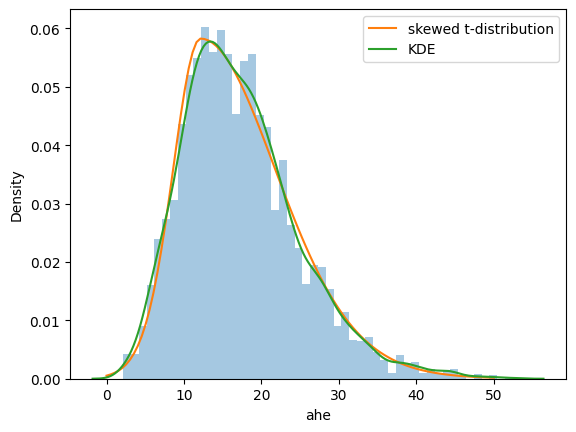

In [25]:
xs = np.linspace(0, 50, 100)

fig, ax = plt.subplots()
ax.hist(male_earnings, bins=50, density=True, alpha=0.4)
ax.plot(xs, dsstd(xs, *fit_t.x), label='skewed t-distribution')
sns.kdeplot(male_earnings, ax=ax, label='KDE')
ax.legend();

#### Problem 5

In [26]:
from common.distr import dsged

In [27]:
loglik_f = lambda beta: np.sum(-np.log(dsged(x, loc=beta[0], scale=beta[1], nu=beta[2], xi=beta[3])))

In [28]:
start = np.array([np.mean(x), np.std(x, ddof=1), 5, 1])

In [29]:
fit_ged = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None), (0, None)])
fit_ged

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20120.980760953444
        x: [ 1.734e+01  7.501e+00  1.771e+00  1.655e+00]
      nit: 16
      jac: [ 7.276e-04  0.000e+00 -1.091e-03  2.910e-03]
     nfev: 95
     njev: 19
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

The estimate of the power under exponent:

In [30]:
fit_ged.x[2]

1.7709485066467947

The estimate of $\xi$:

In [31]:
fit_ged.x[3]

1.6549877348295312

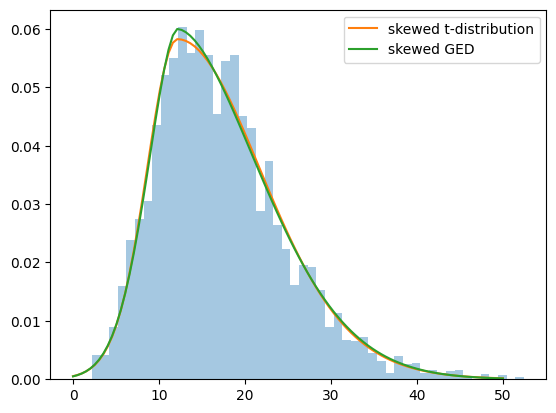

In [32]:
xs = np.linspace(0, 50, 100)

fig, ax = plt.subplots()
ax.hist(male_earnings, bins=50, density=True, alpha=0.4)
ax.plot(xs, dsstd(xs, *fit_t.x), label='skewed t-distribution')
ax.plot(xs, dsged(xs, *fit_ged.x), label='skewed GED')
ax.legend();

The fit of the skewed GED distribution is very close to that of the skewed t-distribution.

### 5.19.2 DAX Returns

In [33]:
levels = pd.read_csv('../data/EuStockMarkets.csv', usecols=[1, 2, 3, 4, 5], index_col=0)
levels.head()

,DAX,SMI,CAC,FTSE
date,,,,
1991.496154,1628.75,1678.1,1772.8,2443.6
1991.500000,1613.63,1688.5,1750.5,2460.2
1991.503846,1606.51,1678.6,1718.0,2448.2
1991.507692,1621.04,1684.1,1708.1,2470.4
1991.511538,1618.16,1686.6,1723.1,2484.7


In [34]:
x = np.log(levels['DAX']).diff().dropna()

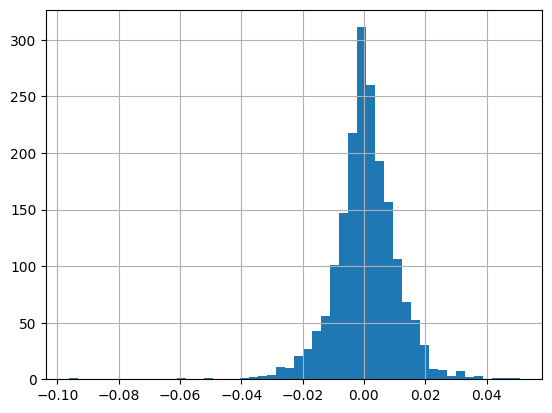

In [35]:
x.hist(bins=50);

In [36]:
np.mean(x)

0.0006520417476913269

In [37]:
np.std(x, ddof=1)

0.010300836598995541

In [38]:
stats.skew(x)

-0.5540533145238529

#### Problem 6

Fit the symmetric t-distribution:

In [39]:
def loglik_t(x: np.ndarray | pd.Series, loc: float, scale: float, df: int) -> float:
    return np.sum(-stats.t.logpdf(x, loc=loc, scale=scale, df=df))

In [40]:
# this functionality is available as `scipy.stats.t.fit`
def fit_t_distr(x: np.ndarray | pd.Series):
    start = np.array([np.mean(x), np.std(x, ddof=1), 2])
    bounds = [(None, None), (0.001, None), (1, None)]
    return minimize(lambda beta: loglik_t(x, *beta), start, method='L-BFGS-B', bounds=bounds)

In [41]:
fit_t = fit_t_distr(x)
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -5983.3218657241
        x: [ 7.846e-04  7.539e-03  4.195e+00]
      nit: 25
      jac: [-1.846e+00  4.169e-01  1.091e-03]
     nfev: 124
     njev: 31
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [42]:
from common.misc import aic, bic

In [43]:
aic(fit_t)

-11960.6437314482

Fit the skewed t-distribution:

In [44]:
loglik_f = lambda beta: np.sum(-np.log(dsstd(x, mean=beta[0], sd=beta[1], nu=beta[2], xi=beta[3])))

In [45]:
start = np.array([np.mean(x), np.std(x, ddof=1), 3, 1])

In [46]:
fit_skt = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None), (0, None)])
fit_skt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -5983.432881793502
        x: [ 7.303e-04  1.042e-02  4.208e+00  9.860e-01]
      nit: 39
      jac: [-1.117e-01 -1.142e-01  0.000e+00  1.091e-03]
     nfev: 225
     njev: 45
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [47]:
aic(fit_skt)

-11958.865763587004

The AIC values are very close for the two fits, the skewed distribution has a slightly lower value, so can be preferred.

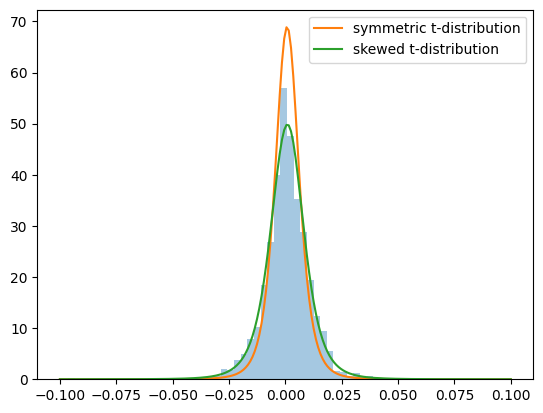

In [48]:
xs = np.linspace(-0.1, 0.1, 200)

fig, ax = plt.subplots()
ax.hist(x, bins=50, density=True, alpha=0.4)
ax.plot(xs, dsstd(xs, *fit_t.x, xi=1), label='symmetric t-distribution')
ax.plot(xs, dsstd(xs, *fit_skt.x), label='skewed t-distribution')
ax.legend();

#### Problems 8 and 9

In [49]:
fit_t.x

array([7.84637913e-04, 7.53887970e-03, 4.19472091e+00])

In [50]:
def tkde(y):
    t_params = {'loc': fit_t.x[0], 'scale': fit_t.x[1] * np.sqrt((fit_t.x[2] - 2) / fit_t.x[2]), 'df': fit_t.x[2]}

    # tranform the input values into a more uniform space and fit a KDE
    x = stats.norm.ppf(stats.t.cdf(y, **t_params))
    kde = KernelDensity(bandwidth=silverman_bw(x), kernel='gaussian').fit(x.reshape(-1, 1))

    def func(y):
        # the input needs to be transform into the uniform space where we fit the KDE
        x = stats.norm.ppf(stats.t.cdf(y, **t_params))
        
        # the output needs to be transform back to the original space
        gprime_num = stats.t.pdf(y, **t_params)
        gprime_den = stats.norm.pdf(stats.norm.ppf(stats.t.cdf(y, **t_params)))
        gprime = gprime_num / gprime_den
        return np.exp(kde.score_samples(x.reshape(-1, 1))) * np.abs(gprime)
    
    return func

In [51]:
tkde_f = tkde(x)

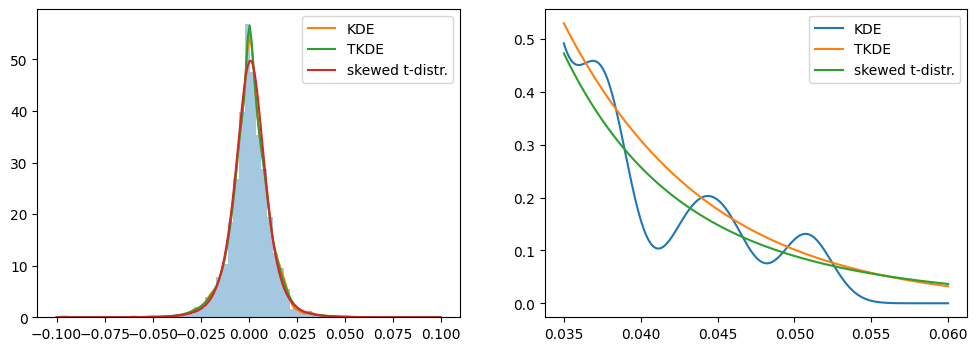

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

kde = KernelDensity(bandwidth=silverman_bw(x), kernel='gaussian').fit(x.values.reshape(-1, 1))

xs = np.linspace(-0.1, 0.1, 200)
vals = np.exp(kde.score_samples(xs.reshape(-1, 1)))

axs[0].hist(x, bins=50, density=True, alpha=0.4)
axs[0].plot(xs, vals, label='KDE')
axs[0].plot(xs, tkde_f(xs), label='TKDE')
axs[0].plot(xs, dsstd(xs, *fit_skt.x), label='skewed t-distr.')
axs[0].legend();

xs = np.linspace(0.035, 0.06, 500)
vals = np.exp(kde.score_samples(xs.reshape(-1, 1)))

axs[1].plot(xs, vals, label='KDE')
axs[1].plot(xs, tkde_f(xs), label='TKDE')
axs[1].plot(xs, dsstd(xs, *fit_skt.x), label='skewed t-distr.')
axs[1].legend();

The TKDE and the parametric estimate are similar and provide a smoother approximation of the empirical distribution.

#### Problem 10

In [53]:
x = np.log(levels['FTSE']).diff().dropna()

In [54]:
loglik_f = lambda beta: np.sum(-np.log(dsstd(x, mean=beta[0], sd=beta[1], nu=beta[2], xi=beta[3])))

In [55]:
start = np.array([np.mean(x), np.std(x, ddof=1), 3, 1])

In [56]:
fit_skt = minimize(loglik_f, start, method='L-BFGS-B', bounds=[(-1, None), (0.001, None), (1, None), (0, None)])
fit_skt

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -6399.526504488529
        x: [ 4.318e-04  7.923e-03  6.657e+00  9.948e-01]
      nit: 45
      jac: [ 4.957e-02 -4.366e-02  0.000e+00 -1.819e-04]
     nfev: 260
     njev: 52
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [57]:
mle_se(fit_skt.x, loglik_f)

array([1.82521215e-04, 2.15107414e-04, 1.44375158e+00, 3.17420938e-02])

In [58]:
aic(fit_skt)

-12791.053008977058

### 5.19.3 McDonald's Returns

In [59]:
data = pd.read_csv('../data/MCD_PriceDaily.csv', index_col=0, parse_dates=[0])
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,62.63,63.07,62.31,62.78,5839300,53.99
2010-01-05,62.66,62.75,62.19,62.30,7099000,53.58
2010-01-06,62.20,62.41,61.06,61.45,10551300,52.85
2010-01-07,61.25,62.34,61.11,61.90,7517700,53.24
2010-01-08,62.27,62.41,61.60,61.84,6107300,53.19


In [60]:
x = np.log(data['Adj Close']).diff().dropna()

In [61]:
fit_t = fit_t_distr(x)
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3940.5770575954457
        x: [ 6.405e-04  6.638e-03  4.276e+00]
      nit: 29
      jac: [ 1.819e-02  1.026e-01 -9.095e-05]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

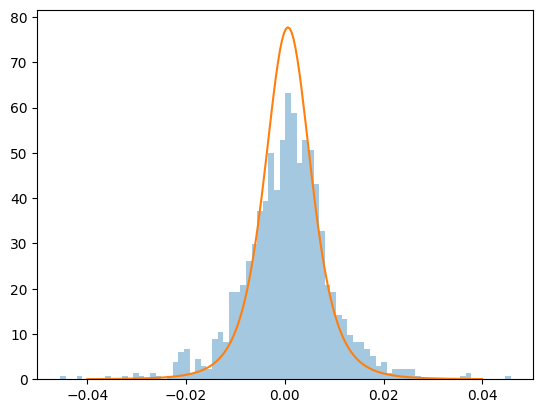

In [62]:
xs = np.linspace(-0.04, 0.04, 200)

fig, ax = plt.subplots()
ax.hist(x, bins=80, density=True, alpha=0.4)
ax.plot(xs, dsstd(xs, *fit_t.x, xi=1), label='symmetric t-distribution');

The fit is not very good in the central region.

#### Problem 12

In [63]:
mle_se(fit_t.x, lambda beta: loglik_t(x, loc=beta[0], scale=beta[1], df=beta[2]))

array([2.27700058e-04, 2.59205241e-04, 6.19479716e-01])

Given that the mean MLE is significantly smaller in absolute value than the standard error of the estimate, we conclude that the mean is not significantly different from 0.

#### Problem 13

The fit should be improved either by using non-parameteric methods or a better parameterisation. In particular, the empirical distribution is skewed, so a skewed variant could be fitted:

In [64]:
stats.skew(x)

-0.16042138396194558

#### Problem 14

The tails of the fitted distribution appear to be reasonable in terms of capturing the outliers.

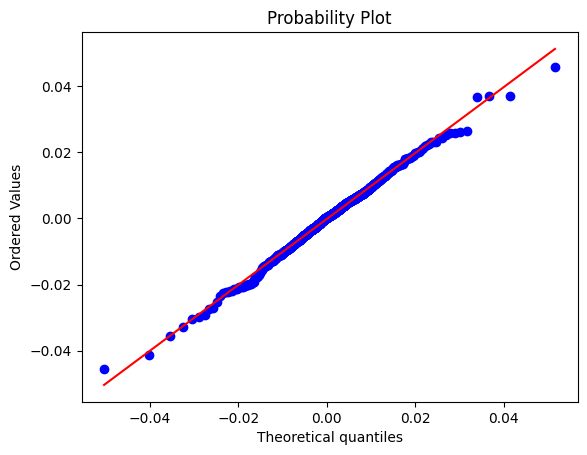

In [65]:
fig, ax = plt.subplots()
stats.probplot(x, dist="t", sparams=(fit_t.x[2], fit_t.x[0], fit_t.x[1]), plot=ax);

The fitted distribution has finite kurtosis, since $\nu = 4.276 > 4$.